Station: ZE.2303..GPZ

Processing data for 2023-07-13T00:00:00.000000Z to 2023-07-14T00:00:00.000000Z
Resampling...
Trace added
Data accumulated for 1.0-day periods starting on 2023-07-13T00:00:00.000000Z
Processed times: [UTCDateTime(2023, 7, 13, 0, 0), UTCDateTime(2023, 7, 13, 0, 30), UTCDateTime(2023, 7, 13, 1, 0), UTCDateTime(2023, 7, 13, 1, 30), UTCDateTime(2023, 7, 13, 2, 0), UTCDateTime(2023, 7, 13, 2, 30), UTCDateTime(2023, 7, 13, 3, 0), UTCDateTime(2023, 7, 13, 3, 30), UTCDateTime(2023, 7, 13, 4, 0), UTCDateTime(2023, 7, 13, 4, 30)]


<Figure size 1000x600 with 0 Axes>

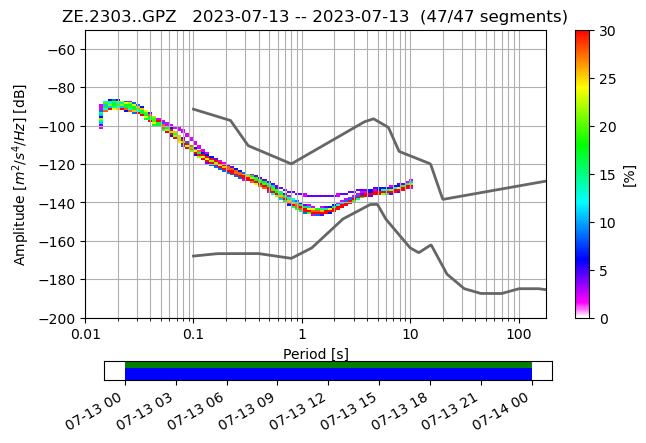

Shape of psd values:  (47, 77)


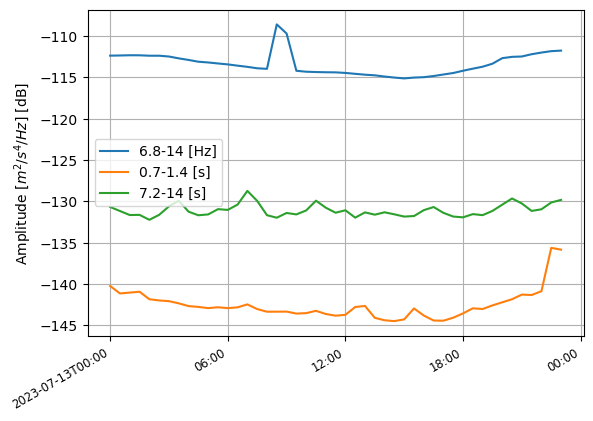


Processing data for 2023-07-14T00:00:00.000000Z to 2023-07-15T00:00:00.000000Z
Resampling...
Trace added
Data accumulated for 1.0-day periods starting on 2023-07-14T00:00:00.000000Z
Processed times: [UTCDateTime(2023, 7, 14, 0, 0), UTCDateTime(2023, 7, 14, 0, 30), UTCDateTime(2023, 7, 14, 1, 0), UTCDateTime(2023, 7, 14, 1, 30), UTCDateTime(2023, 7, 14, 2, 0), UTCDateTime(2023, 7, 14, 2, 30), UTCDateTime(2023, 7, 14, 3, 0), UTCDateTime(2023, 7, 14, 3, 30), UTCDateTime(2023, 7, 14, 4, 0), UTCDateTime(2023, 7, 14, 4, 30)]


<Figure size 1000x600 with 0 Axes>

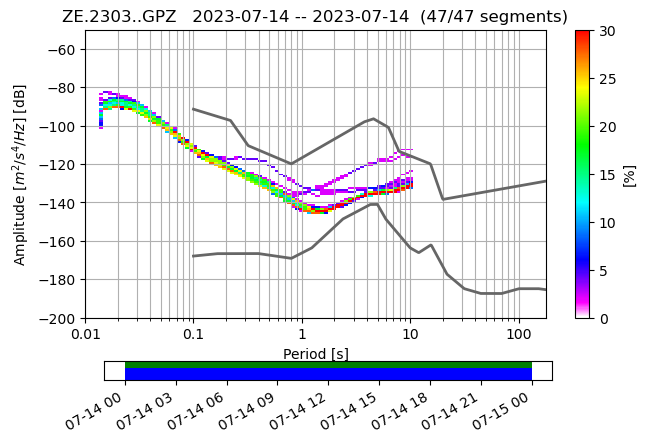

Shape of psd values:  (47, 77)


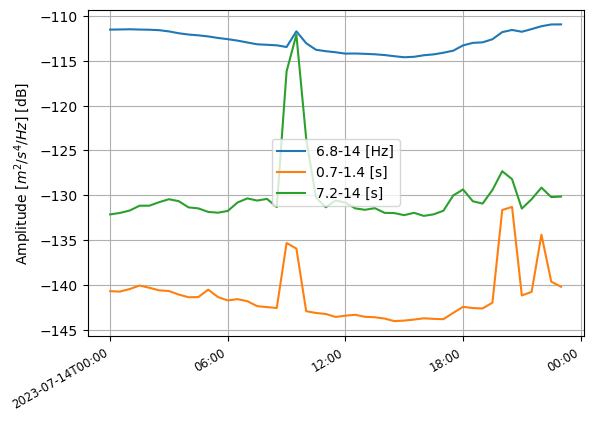


Processing data for 2023-07-15T00:00:00.000000Z to 2023-07-16T00:00:00.000000Z
Resampling...
Trace added
Data accumulated for 1.0-day periods starting on 2023-07-15T00:00:00.000000Z
Processed times: [UTCDateTime(2023, 7, 15, 0, 0), UTCDateTime(2023, 7, 15, 0, 30), UTCDateTime(2023, 7, 15, 1, 0), UTCDateTime(2023, 7, 15, 1, 30), UTCDateTime(2023, 7, 15, 2, 0), UTCDateTime(2023, 7, 15, 2, 30), UTCDateTime(2023, 7, 15, 3, 0), UTCDateTime(2023, 7, 15, 3, 30), UTCDateTime(2023, 7, 15, 4, 0), UTCDateTime(2023, 7, 15, 4, 30)]


<Figure size 1000x600 with 0 Axes>

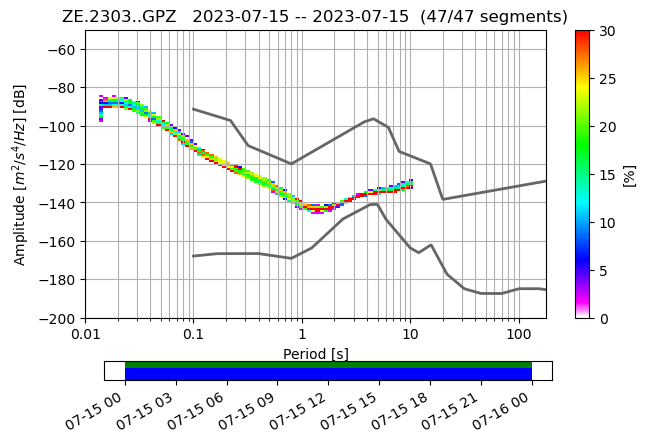

Shape of psd values:  (47, 77)


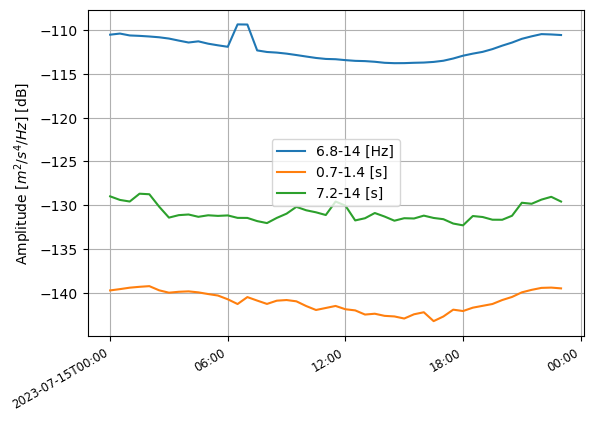

In [3]:
#Working from documentation for Visualizing Probabalistic Power Spectra Densities in the OBSPY 1.4.1 user guide.
#Objective is to determine a strategy for assessing signal quality between different sites and times.
#Signals validated by whatever tool can be produced here are intended to be of enough quality to carry forward for figures and additional analysis

#st = read("https://examples.obspy.org/BW.KW1..EHZ.D.2011.037")
#tr = st.select(id="BW.KW1..EHZ")[0]

import obspy
from obspy import read, UTCDateTime
from obspy.io.xseed import Parser
from obspy.signal import PPSD
import numpy as np
import matplotlib.pyplot as plt
from obspy.imaging.cm import pqlx
import os
from obspy.clients.fdsn import Client
from datetime import timedelta

## example with ZE 2303 GPZ
# date range: 2023-07-12 to 2023-09-08
# but exclude first and last day for cleaner data

# define start and end time for the data range
start_date = UTCDateTime(2023, 7, 13)  # Start time
end_date = UTCDateTime(2023, 7, 16)  # End time
delta = timedelta(days=1)  # define time interval between each iteration (1 day), can just use seconds instead

# define path where .mseed files are stored
path = 'C:/Users/zzawol/Documents/seismic-data-iris/seismic_data/NO2303'
stas = ['ZE.2303..GPZ']  # station IDs
if not os.path.exists(path):
    os.makedirs(path, exist_ok=True)

# set station info
nowsta = stas[0]
network, station, location, channel = nowsta.split('.')
print(f"Station: {nowsta}")

# define the file pattern for reading mseed files
# assuming filenames follow the pattern 'ZE.2304..GPZ_YYYYMMDDTHHMMSS.mseed'
file_pattern = f'{path}/{network}.{station}.*.{channel}*.mseed'

# set up metadata
client = Client("IRISPH5", timeout=600) # timeout (s) - time before connection timeout is raised, default 10s
inv = client.get_stations(network=network, station=station, location=location, channel=channel, level='response')  

# loop through each day in the date range
current_date = start_date
while current_date < end_date:
    t1 = current_date
    t2 = current_date + delta  # The next day
    print(f"\nProcessing data for {t1} to {t2}")

    try: # read data for the current day
        S = obspy.read(file_pattern, starttime=t1, endtime=t2)
    except Exception as e:
        print(f"Error reading data for {t1} to {t2}: {e}")
        current_date += delta
        continue  # skip to next date if there's an error reading data

    # merge traces to avoid duplicates
    S.merge(method=1)

    # # prefiltering for instrument's frequency bandwidth, do before preprocessing
    # for tr in S:
    #     pre_filt = [0.01, 1, 100, 150] # values TBD # 4 corner frequencies
    #     tr.remove_response(inventory=inv, pre_filt=pre_filt, plot=True) # , output="DISP", water_level=60, plot=True)  
    
    # resample the data
    print('Resampling...')
    S.resample(100)  # Resampled rate for final analysis. Note: Consider Nyquist criterion

    # create PPSD object and add traces
    ppsd = None
    for tr in S:
        if ppsd is None:
            ppsd = PPSD(tr.stats, metadata=inv, period_limits=(0.01, 10.0))
        ppsd.add(tr)
        print('Trace added')

    # plot the PPSD for the current day
    if ppsd is not None and len(ppsd.times_processed) > 0:
        print(f"Data accumulated for {(t2-t1)/(60*60*24)}-day periods starting on {t1}")
        print("Processed times:", ppsd.times_processed[:10])  # see first 10 times processed
        
        # plot the PPSD
        plt.figure(figsize=(10, 6))
        ppsd.plot(cmap=pqlx)
        psd_values = ppsd.psd_values
        print("Shape of psd values: ", np.shape(psd_values))
        #print(psd_values[0:1]) # first branch
        
        # plotting time series of PSD values
        ppsd.plot_temporal([0.1,1,10])
        
        # save the plot as .png
        #plot_filename = f"ppsd_plot_{t1.date}.png" # change title if more than one date
        #plt.savefig(plot_filename)
        #print(f"Plot saved as {plot_filename}")
        
        plt.close()  # close plot to avoid displaying it in each iteration
        
    else:
        print(f"No data accumulated for {t1} to {t2}, check if exists")

    # move to the next day
    current_date += delta

